# Phishing Detection App With PyTorch

## Imports

In [1]:
# Cell 1
import os
import re
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from datasets import load_dataset

try:
    from going_modular import data_setup, engine
    from helper_functions import plot_loss_curves
except Exception as e:
    # Get the going_modular and helper_functions scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/JunHL96/PyTorch-Course
    !mv PyTorch-Course/going_modular .
    !mv PyTorch-Course/helper_functions.py .
    !rm -rf PyTorch-Course
    from going_modular import data_setup, engine
    from helper_functions import plot_loss_curves  

## Device Agnostic Code

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print("Using device:", device)

Using device: mps



## Phishing Dataset Documentation  



This dataset is a compilation of phishing and benign (non-phishing) data from multiple sources, preprocessed for machine learning tasks such as classification and phishing detection.  

### Dataset Overview
- **Preprocessing**:  
  - Null, empty, and duplicate entries have already been removed.  
  - Class balancing has been applied to mitigate biases.  
- **Structure**:  
  - Two columns: `text` (input data) and `label` (binary classification).  
    - `text` may contain: **URLs**, **SMS messages**, **email bodies**, or **HTML code**.  
    - `label`: `1` (Phishing) or `0` (Benign).  


### Source Data  
The dataset combines four distinct sources:  

#### 1. **Email Dataset**  
- **Source**: Enron Corporation employee emails.  
- **Size**: Over 18,000 emails.  
- **Use Case**: Text analysis for phishing email detection.  

#### 2. **SMS Dataset**  
- **Source**: Internet-collected SMS messages.  
- **Size**: 5,971 messages (489 Spam, 638 Smishing, 4,844 Ham).  
- **Collection Method**: Converted from images to text via Python.  

#### 3. **URL Dataset**  
- **Source**: Aggregated from JPCERT, Kaggle, GitHub, and open-source databases.  
- **Size**: 800,000+ URLs (52% legitimate, 47% phishing).  
- **Update Frequency**: URLs refreshed annually.  

#### 4. **Website Dataset**  
- **Sources**:  
  - **Legitimate**: Google search results (top 5 URLs per query) + Ebbu2017 Phishing Dataset.  
  - **Phishing**: PhishTank, OpenPhish, PhishRepo.  
- **Size**: 80,000 instances (50,000 legitimate, 30,000 phishing).  
- **Diversity**: Domain restrictions applied (max 10 entries per domain).  




In [3]:
# Cell 2
dataset = load_dataset("ealvaradob/phishing-dataset", "combined_reduced", trust_remote_code=True)
df = dataset["train"].to_pandas()

def clean_text(text):
    # Replace HTML tags with a space
    text = re.sub(r"</?[^>]+>", " ", text)
    # Convert to lowercase
    text = text.lower()
    # Replace non-alphanumeric characters with a space
    text = re.sub(r"[^a-z0-9]", " ", text)
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)
display(df[['clean_text', 'label']].head())

,clean_text,label
0,clipper servicing and repair clippersharp ltd ...,0
1,http online0mgeving ga triodos,1
2,metronews ca webapp login aspx logout true rur...,0
3,https rarkuntem co jp fpjiehk cn index1 php,1
4,freebase com view m 0ct05qn,0


In [4]:
%%writefile going_modular/transformer_model.py
import torch
import torch.nn as nn
from transformers import DistilBertModel

class TransformerTextClassifier(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(TransformerTextClassifier, self).__init__()
        # Load pretrained DistilBERT model
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        hidden_size = self.bert.config.hidden_size  # typically 768
        # Batch normalization applied on the CLS token
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Expects x to be a dict with keys 'input_ids' and 'attention_mask'.
        """
        input_ids = x["input_ids"]
        attention_mask = x["attention_mask"]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the first token ([CLS]) representation for classification
        cls_token = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
        normalized = self.batchnorm(cls_token)
        dropped = self.dropout(normalized)
        logits = self.classifier(dropped)
        return logits

Overwriting going_modular/transformer_model.py


In [5]:
%%writefile going_modular/data_augmentation.py
import random

def random_deletion(tokens, deletion_prob=0.1):
    """
    Randomly delete tokens with a given probability.
    If all tokens are deleted, returns the original list.
    """
    if not tokens:
        return tokens
    new_tokens = [token for token in tokens if random.random() > deletion_prob]
    return new_tokens if new_tokens else tokens

def augment_text(tokens, deletion_prob=0.1):
    """
    Augment a list of tokens using random deletion.
    """
    return random_deletion(tokens, deletion_prob)

Overwriting going_modular/data_augmentation.py


In [6]:
# Cell 5
import torch
from torch.utils.data import Dataset, random_split
from transformers import DistilBertTokenizer
from going_modular.data_augmentation import augment_text

# Load the DistilBert tokenizer
# pretrained weights are downloaded and cached during the first run
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Helper class to wrap batched tensors and support .to(device)
class TransformerBatchCollated:
    def __init__(self, batch_dict):
        self.batch_dict = batch_dict
    def to(self, device):
        new_dict = {k: v.to(device) for k, v in self.batch_dict.items()}
        return TransformerBatchCollated(new_dict)
    # To allow dictionary-like access
    def __getitem__(self, key):
        return self.batch_dict[key]
    def keys(self):
        return self.batch_dict.keys()
    def items(self):
        return self.batch_dict.items()

# Custom collate function for the DataLoader
def transformer_collate_fn(batch):
    """
    Expects batch to be a list of tuples: (dict of tensors from a single example, label).
    Returns a tuple: (TransformerBatchCollated, labels tensor)
    """
    # Each element of batch is a tuple: (batch_item_dict, label)
    # We want to stack each key from the dictionaries.
    input_ids = torch.stack([item[0]["input_ids"] for item in batch])
    attention_mask = torch.stack([item[0]["attention_mask"] for item in batch])
    labels = torch.stack([item[1] for item in batch])
    batch_dict = {"input_ids": input_ids, "attention_mask": attention_mask}
    return (TransformerBatchCollated(batch_dict), labels)

# Dataset class for transformer-based phishing detection
class TransformerPhishingDataset(Dataset):
    def __init__(self, df, max_len=128, augmentation_fn=None):
        """
        df: DataFrame containing at least 'clean_text' and 'label' columns.
        augmentation_fn: Function to augment tokenized text (applied only during training).
        """
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.augmentation_fn = augmentation_fn
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get the cleaned text and label
        text = self.df.loc[idx, "clean_text"]
        label = self.df.loc[idx, "label"]
        
        # Tokenize by splitting on whitespace; apply augmentation if provided
        tokens = text.split()
        if self.augmentation_fn is not None:
            tokens = self.augmentation_fn(tokens)
        # Reconstruct the text after augmentation
        aug_text = " ".join(tokens)
        
        # Encode using the DistilBERT tokenizer
        encoding = tokenizer.encode_plus(
            aug_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        # Squeeze to remove extra dimensions
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        
        # Return a tuple: (dictionary of tensors, label)
        example_dict = {"input_ids": input_ids, "attention_mask": attention_mask}
        return (example_dict, torch.tensor(label, dtype=torch.long))

# Create the full transformer dataset using our DataFrame and augmentation function
full_transformer_dataset = TransformerPhishingDataset(df, max_len=128, augmentation_fn=augment_text)

In [7]:
# Cell 6
train_size = int(0.8 * len(full_transformer_dataset))
test_size = len(full_transformer_dataset) - train_size
train_dataset_transformer, test_dataset_transformer = random_split(full_transformer_dataset, [train_size, test_size])

print("Transformer train dataset size:", len(train_dataset_transformer))
print("Transformer test dataset size:", len(test_dataset_transformer))

# Create DataLoaders with the custom collate function
BATCH_SIZE_TRANSFORMER = 32
train_loader_transformer = DataLoader(train_dataset_transformer, batch_size=BATCH_SIZE_TRANSFORMER, shuffle=True, collate_fn=transformer_collate_fn)
test_loader_transformer = DataLoader(test_dataset_transformer, batch_size=BATCH_SIZE_TRANSFORMER, collate_fn=transformer_collate_fn)

Transformer train dataset size: 62141
Transformer test dataset size: 15536


In [8]:
# Cell 7 (Modified for device-agnostic training)
import torch
import torch.nn as nn
import torch.optim as optim
from going_modular import engine
from going_modular.transformer_model import TransformerTextClassifier

# Hyperparameters for transformer training
EPOCHS_TRANSFORMER = 3  # Adjust as needed
LEARNING_RATE_TRANSFORMER = 2e-5

# Instantiate the transformer model and move to the selected device
model_transformer = TransformerTextClassifier(num_classes=2, 
                                              dropout_prob=0.5)
model_transformer.to(device)

# Loss and optimizer (using AdamW is common with transformers)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_transformer.parameters(), 
                        lr=LEARNING_RATE_TRANSFORMER)

# Train the transformer-based model using the modular engine
results_transformer = engine.train(model=model_transformer,
                                   train_dataloader=train_loader_transformer,
                                   test_dataloader=test_loader_transformer,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=EPOCHS_TRANSFORMER,
                                   device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2851 | train_acc: 0.8784 | test_loss: 0.1962 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.1690 | train_acc: 0.9345 | test_loss: 0.1666 | test_acc: 0.9378
Epoch: 3 | train_loss: 0.1235 | train_acc: 0.9535 | test_loss: 0.1649 | test_acc: 0.9368


Loss: 0.1606
Accuracy: 0.9376
Precision: 0.9560
Recall: 0.8895
False Positive Rate: 0.0287


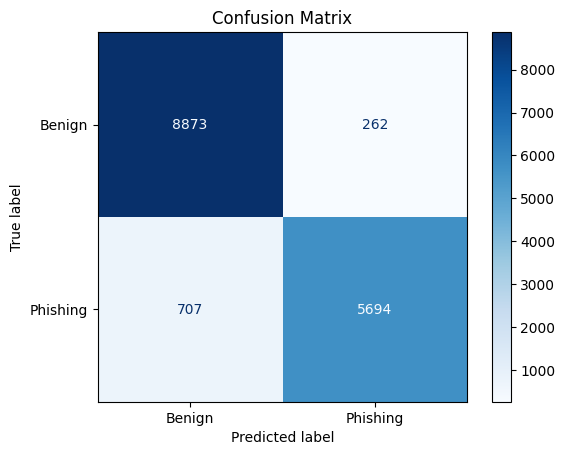

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model on the test set
model_transformer.eval()
all_preds = []
all_labels = []
test_loss_total = 0

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader_transformer):
        inputs = X.to(device)
        outputs = model_transformer(inputs)
        loss = loss_fn(outputs, y.to(device))
        test_loss_total += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute average test loss
avg_loss = test_loss_total / len(test_loader_transformer)

# Compute accuracy, precision, recall
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)

# Compute confusion matrix and false positive rate
cm = confusion_matrix(all_labels, all_preds)
TN, FP, FN, TP = cm.ravel()
false_positive_rate = FP / (FP + TN)

print(f"Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Cell 9
from pathlib import Path
import shutil
import os

# Create directory structure for deployable app
demo_dir = Path("demos/phishing_email")
examples_dir = demo_dir / "examples"

# If the directory exists, remove it and create fresh directories
if demo_dir.exists():
    shutil.rmtree(demo_dir)
demo_dir.mkdir(parents=True, exist_ok=True)
examples_dir.mkdir(parents=True, exist_ok=True)

# For demonstration, let's write some example emails to the examples directory.
# (In a real scenario you might want to have realistic examples.)
example_emails = [
    "Dear customer, your account has been compromised. Click here to reset your password.",
    "Congratulations! You've won a lottery. Please send your bank details to claim the prize.",
    "Meeting at 10am tomorrow. Please review the attached agenda.",
    "Urgent: Your invoice is overdue. Please remit payment immediately.",
    "Hi, just checking in to see if you received my previous email.",
]

# Save each example email as a text file in the examples folder
for i, email in enumerate(example_emails):
    with open(examples_dir / f"email_{i+1}.txt", "w") as f:
        f.write(email)


In [33]:
%%writefile demos/phishing_email/model.py

# Write model.py file (this file loads the transformer model from its state_dict)

import torch
import torch.nn as nn
from transformers import DistilBertModel

class TransformerTextClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(TransformerTextClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        hidden_size = self.bert.config.hidden_size  # typically 768
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        input_ids = x["input_ids"]
        attention_mask = x["attention_mask"]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        normalized = self.batchnorm(cls_token)
        dropped = self.dropout(normalized)
        logits = self.classifier(dropped)
        return logits

def load_model(model_path: str, device: torch.device):
    model = TransformerTextClassifier(num_classes=2, dropout_prob=0.5)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# End of model.py


Writing demos/phishing_email/model.py


In [34]:

# Save the trained model using the utility function from going_modular/utils.py
from going_modular import utils
utils.save_model(model=model_transformer, target_dir="demos/phishing_email", model_name="transformer_phishing_model.pth")



[INFO] Saving model to: demos/phishing_email/transformer_phishing_model.pth


In [35]:

%%writefile demos/phishing_email/app.py

# Write app.py file to deploy the Gradio app

import os
import torch
import gradio as gr
import re
from transformers import DistilBertTokenizer
from timeit import default_timer as timer
from demos.phishing_email.model import load_model

# For inference, always load to CPU for Hugging Face Spaces compatibility
device = torch.device("cpu")

# Load the model (ensure the saved state_dict file is in the correct path)
model = load_model("demos/phishing_email/transformer_phishing_model.pth", device)

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def clean_text(text):
    text = re.sub(r"</?[^>]+>", " ", text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def predict_email(email: str):
    start_time = timer()
    # Clean the input text
    email_clean = clean_text(email)
    # Tokenize using the DistilBertTokenizer
    encoding = tokenizer.encode_plus(
        email_clean,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    inputs = {"input_ids": encoding["input_ids"].to(device),
              "attention_mask": encoding["attention_mask"].to(device)}
    with torch.inference_mode():
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)
    # For binary classification: index 0 -> Benign, index 1 -> Phishing.
    prob_benign = float(probs[0][0])
    prob_phishing = float(probs[0][1])
    pred_time = round(timer() - start_time, 5)
    return {"Benign": prob_benign, "Phishing": prob_phishing}, pred_time

# Load examples from the examples directory
example_dir = "demos/phishing_email/examples"
example_list = []
if os.path.exists(example_dir):
    for file in os.listdir(example_dir):
        with open(os.path.join(example_dir, file), "r") as f:
            example_list.append([f.read().strip()])

title = "Phishing Email Detector"
description = (
    "This app detects phishing from various text sources (emails, SMS, URLs, HTML) using a transformer-based model. "
    "The dataset is a compilation of phishing and benign data, preprocessed and balanced for classification."
)
article = "Deploying a transformer-based phishing detector with Gradio."

# Create the Gradio interface
demo = gr.Interface(
    fn=predict_email,
    inputs=gr.Textbox(lines=5, placeholder="Enter email, SMS, URL or HTML content here..."),
    outputs=[gr.Label(num_top_classes=2, label="Predictions"),
             gr.Number(label="Prediction Time (s)")],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

if __name__ == "__main__":
    demo.launch()

Writing demos/phishing_email/app.py


In [36]:
# Cell 10: Launch Gradio App for Phishing Detection (Updated)
import gradio as gr
import os
import torch
import re
from transformers import DistilBertTokenizer
from timeit import default_timer as timer

# For this demo, we load the saved model from our demos/phishing_email directory
from demos.phishing_email.model import load_model

# Device for inference: force CPU for HF Spaces compatibility
device = torch.device("cpu")
print("Inference device:", device)

# Load the model (make sure the saved state_dict is at the correct path)
model = load_model("demos/phishing_email/transformer_phishing_model.pth", device)

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def clean_text(text):
    """Clean text input using similar preprocessing as training."""
    text = re.sub(r"</?[^>]+>", " ", text)  # remove HTML tags
    text = text.lower()
    text = re.sub(r"[^a-z0-9]", " ", text)   # remove non-alphanumerics
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def predict_email(email: str):
    """Predict whether an input text is phishing or benign.
       Returns a dictionary mapping class labels to probabilities and inference time.
    """
    start_time = timer()
    # Preprocess the input email
    email_clean = clean_text(email)
    encoding = tokenizer.encode_plus(
        email_clean,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    inputs = {"input_ids": encoding["input_ids"].to(device),
              "attention_mask": encoding["attention_mask"].to(device)}
    with torch.inference_mode():
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)
    # For binary classification: class 0: Benign, class 1: Phishing.
    prob_benign = float(probs[0][0])
    prob_phishing = float(probs[0][1])
    pred_time = round(timer() - start_time, 5)
    
    # Return dictionary as required by gr.Label and the prediction time.
    return {"Benign": prob_benign, "Phishing": prob_phishing}, pred_time

# Create examples for the demo.
# These examples include various types of text found in the dataset: emails, SMS messages, URLs, HTML snippets.
example_texts = [
    "Dear customer, your account has been compromised. Click here to reset your password.",
    "Urgent: Your invoice is overdue. Please remit payment immediately.",
    "Hi there, just checking in on our meeting schedule for next week.",
    "Visit our site at http://example-update.com to verify your information.",
    "<html><body>Congratulations! You've won a prize. Please send your bank details.</body></html>"
]
example_list = [[example] for example in example_texts]

# Description containing dataset details
description = (
    "This app detects phishing using a transformer-based model fine-tuned on a diverse dataset. "
    "The dataset includes emails, SMS messages, URLs, and HTML code. "
    "Labels: 'Phishing' if the message is phishing; 'Benign' if it is legitimate. "
    "Preprocessing has removed nulls, duplicates, and balanced the classes."
)

# Create the Gradio interface
demo = gr.Interface(
    fn=predict_email,
    inputs=gr.Textbox(lines=5, placeholder="Enter email, SMS, URL, or HTML content here..."),
    outputs=[gr.Label(num_top_classes=2, label="Predictions"),
             gr.Number(label="Prediction Time (s)")],
    examples=example_list,
    title="Phishing Detection App",
    description=description,
    article="This demo uses a transformer-based model (DistilBERT) fine-tuned for phishing detection."
)

# Launch the demo (this will open a local browser window to preview the app)
demo.launch()

Inference device: cpu
* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
